# Notes

This notebook compares periodicity search methods for R1 data.

Methods compared:

- Lomb Scargle
- Kenzie Chisquared
- FRBPA (i.e. Rajwade et al. 2020)

Based on codes:

- R1_Activity_Plots.ipynb
- R1_Load_Data.ipynb
- test_frbpa.ipynb


# Imports

In [17]:
import json
import astropy

import numpy as np

from astropy.time import Time
from frbpa.utils import get_phase
from astropy.modeling import models, fitting
from frbpa.search import riptide_search, p4j_search

from astropy import units as u
from matplotlib import pyplot as plt
from scipy.signal import lombscargle as ls
from astropy.timeseries import TimeSeries as ts

# Functions

In [18]:
#Kenzie Nimmo's ChiSq code:

def chisq(N,exp):
    """
    N = binned number of bursts
    exp = exposure time per bin
    """
    p=float(np.sum(N)/np.sum(exp))

    E = np.zeros_like(N)
    for binno in range(len(N)):
        E[binno] = p*exp[binno]
    
    chisq_stat=np.sum((N-E)**2/(E))
    
    return chisq_stat


def folding(beginp,endp,bins,burst_times,begin_times,end_times):
    """
    beginp and endp are the beginning and end trial periods to fold in days
    bins is an integer number of bins to divide your period into
    burst_times is an array of the observation days which contains a burst
    begin_times is an array of the observation begin times with AND without bursts
    end_times is an array of the observation end times with AND without bursts
    """
    freqs=np.arange(1./float(endp),1./float(beginp),(1./float(bins))/(np.max(burst_times)-np.min(burst_times)))
    #print(freqs)
    periods = np.sort(1./freqs) #days
    #print(periods)
    
    #fig=plt.figure(figsize=(4,3))
    #ax=fig.add_subplot(111)
    #ax.plot(periods,marker='o',label='periods')
    #ax.plot(freqs,marker='o',label='frequencies')
    #ax.legend()
    #plt.show()
    
    t0=begin_times.min()
    tend=end_times.max()

    chisq_values=[]
    ps=[]
    #for pind,p in enumerate(tqdm(periods)): #removed tqdm for now
    for pind,p in enumerate(periods):
        bin_length= p/float(bins) #days
        binned=np.zeros(bins)
        exposure=np.zeros(bins)
        for i in range(int(np.ceil((tend-t0)/bin_length))): #chop up into bins
            if i==0:
                begin_time = t0 + i*bin_length
            else: begin_time = end_time
            end_time = begin_time + bin_length
            above=np.where(burst_times >= begin_time) 
            below=np.where(burst_times < end_time )
            count=len(np.intersect1d(above,below)) #find the bursts within the begin_time and end_time of the bin
            binned[(i)%bins]+=count #adding a count each time a burst falls in a particular bin
            # compute the exposure
            time_before=np.where(begin_times < end_time)
            time_after=np.where(end_times > begin_time)
            overlap_with_bin=np.intersect1d(time_before,time_after)
            for over in range(len(overlap_with_bin)):
                if begin_times[overlap_with_bin[over]] <= begin_time:
                    begin_exp = begin_time
                else: begin_exp = begin_times[overlap_with_bin[over]]
                if end_times[overlap_with_bin[over]] >= end_time:
                    end_exp = end_time
                else: end_exp = end_times[overlap_with_bin[over]]
            exp = ((end_exp-begin_exp)*24.*3600.) 
            exposure[(i)%bins]+=exp #adding exposure per bin in seconds 
        #print(chisq(binned,exposure))
        chisqp=float(chisq(binned,exposure))/(bins-1)
        chisq_values.append(chisqp)
        ps.append(p)
    return chisq_values, ps

# Load data from JSON

In [19]:
#set Cruces+21 -derived period
Cruces_p = 161 #[days]

In [20]:
########################
#load L and C-band data#
########################

jsonfile = 'AnyBand_R1.json' #the file containing the data
#jsonfile = 'LBand_R1.json' #the file containing the data


with open(jsonfile, 'r') as f: #open file
    r1_data = json.load(f) #load all data

#print keys (i.e. data) for reference
print('Data Keys: {0}\n'.format(r1_data.keys())) 


###################################################
#extract keys I will use to filter or process data#
###################################################

burst_dict = r1_data['bursts'] #mjds of bursts
tel_dict = r1_data['obs_tels'] #telescopes of observtions
freq_dict = r1_data['obs_freqs'] #frequencies of observations
dura_dict = r1_data['obs_duration'] #duration of all observations
start_dict = r1_data['obs_startmjds'] #strt mjds of all observations
bpo_dict = r1_data['bursts_per_obs'] #detected events in each observation

#print keys (i.e. particular observing setups) for reference
print('Setup keys: {0}\n'.format(burst_dict.keys())) 

Data Keys: dict_keys(['bursts', 'obs_duration', 'obs_startmjds', 'bursts_per_obs', 'obs_tels', 'obs_freqs', 'references'])

Setup keys: dict_keys(['Cruces21a', 'Hardy17a', 'Houben19a', 'ALFA16a', 'Scholtz16a', 'Hewitt22a', 'Scholtz17a', 'Jahns22a', 'Marcote16a', 'MAGIC17a', 'Rajwade20a', 'Michilli18a', 'Spitler18a', 'Gaijar18a'])



# Extract bursts which will be processed

In [40]:
##################################################################
#construct a data filter (e.g. select only L-band Arecibo bursts)#
##################################################################

#choose filter inputs
minfreq_filter = 1 #[GHz] #inlude bursts detected in bands above this min freq
maxfreq_filter = 2 #[GHz] #include bursts detected in bands below this max freq
telescope_filter = ['Effelsberg','GBT','Arecibo','Lovell','WSRT','MeerKAT'] #telescopes of choice to include data from


#####################################################################################
#loop over all burst data and extract only data from setups which comply with filter#
#####################################################################################

#initialise arrays to hold bursts (and corresponding data) to use
bursts_to_use = [] #mjds of bursts
bpos_to_use = [] #events per observation
duras_to_use = [] #observation durations [s]
starts_to_use = [] #observation start mjds

#pick out bursts to use from all bursts
for k in burst_dict.keys(): #loop over data
    
    print('Telescope: {0}'.format(tel_dict[k]))
    print('Frequency: {0} GHz'.format(freq_dict[k]))
    
    #construct data filter from filter inputs
    data_filter = ((freq_dict[k]>minfreq_filter)&(freq_dict[k]<maxfreq_filter))&(np.isin(tel_dict[k],telescope_filter))
    print('Filter passed: {0}'.format(data_filter))
    
    #select only data which passes filter
    if data_filter==True:
        
        #store selected data to their arrays
        bursts_to_use += burst_dict[k]  #burst mjds
        bpos_to_use += bpo_dict[k] #events per observation
        duras_to_use += dura_dict[k] #observation durations [s]
        starts_to_use += start_dict[k] #start mjds of observations
    
print('bursts to use: {0}'.format(bursts_to_use))

Telescope: Effelsberg
Frequency: 1.36 GHz
Filter passed: True
Telescope: Effelsberg
Frequency: 1.4 GHz
Filter passed: True
Telescope: Effelsberg
Frequency: 1.4 GHz
Filter passed: True
Telescope: Arecibo
Frequency: 1.4 GHz
Filter passed: True
Telescope: Arecibo
Frequency: 1.4 GHz
Filter passed: True
Telescope: Arecibo
Frequency: 1.4 GHz
Filter passed: True
Telescope: Arecibo
Frequency: 1.4 GHz
Filter passed: True
Telescope: Arecibo
Frequency: 1.4 GHz
Filter passed: True
Telescope: Arecibo
Frequency: 1.7 GHz
Filter passed: True
Telescope: Arecibo
Frequency: 1.4 GHz
Filter passed: True
Telescope: Lovell
Frequency: 1.4 GHz
Filter passed: True
Telescope: Arecibo
Frequency: 4.5 GHz
Filter passed: False
Telescope: Effelsberg
Frequency: 4.85 GHz
Filter passed: False
Telescope: GBT
Frequency: 6 GHz
Filter passed: False
bursts to use: [58002.06065, 58002.06079, 58002.06327, 58002.10494, 58002.13924, 58002.16683, 58002.25854, 58440.83884, 58440.86266, 58440.92373, 58440.93681, 58440.98984, 58440.

In [41]:
#do things to data to make them suitable for processing
#with each searching method

#################
#rajwade riptide#
#################

bursts_rajwade_method_search = np.array(bursts_to_use)
bursts_rajwade_method_search = np.sort(bursts_rajwade_method_search - np.min(bursts_rajwade_method_search))

#####################
#cruces lomb scargle#
#####################

bursts_cruces_method_search = np.array(bursts_to_use)
bursts_cruces_method_search.sort()
starts_cruces_method_search = Time(starts_to_use,format='mjd') #start mjds in astropy time format
bpos_cruces_method_search = np.array(bpos_to_use)

####################
#kenzie chi squared#
####################

bursts_nimmo_method_search = np.unique([int(i) for i in np.copy(bursts_to_use)]) #mjds containing observed bursts
starts_nimmo_method_search = np.copy(Time(starts_to_use,format='mjd')) #start mjds in astropy time format
duras_nimmo_method_search = duras_to_use*u.s #durations of obs in astropy seconds

############
#P4J method#
############

bursts_p4j_method_search = np.array(bursts_to_use)

# Riptide periodicity search

In [42]:
 rajwade_cont_frac, rajwade_period = riptide_search(bursts_rajwade_method_search, pmin=2, pmax=2*365)

2022-11-10 16:36:11,624 - riptide_search -root - WARNING - Period/nbins should be greater than tsamp. Not all periods in the given range are valid. Selecting the valid periods from 2.000079342840742 days for search.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25139/25139 [00:19<00:00, 1262.37it/s]
2022-11-10 16:36:31,545 - riptide_search -root - INFO - Max continuous fraction without data is 0.45 at a period of 160.01909611712284 days


# LS periodicity search

In [43]:
#method from: https://jakevdp.github.io/blog/2015/06/13/lomb-scargle-in-python/

#get binary array of event occurences
eventcheck = np.array(bpos_cruces_method_search>0,dtype=int)

#subtract mean as discussed in Cruces+21 and method
eventcheck_ms = eventcheck - np.mean(eventcheck)

#choose periods to search
periods_cruces = np.logspace(0,3,500) #[days]

#from periods, get angular frequencies
ang_freqs_cruces = 2*np.pi/periods_cruces

#perform lomb scargle periodicity search
power_cruces = ls(starts_cruces_method_search.jd,eventcheck_ms,ang_freqs_cruces)

# ChiSq periodicity search

In [44]:
#code inputs

chisq_beginp = 10
chisq_endp = 1000
chisq_bins = 20

#calculate end times of observations
ends_nimmo_method_search = np.copy((starts_nimmo_method_search+duras_nimmo_method_search).value)

#run code for Arecibo data
powers_nimmo,periods_nimmo = folding(chisq_beginp,
                                     chisq_endp,
                                     chisq_bins,
                                     bursts_nimmo_method_search,
                                     starts_nimmo_method_search.value,
                                     ends_nimmo_method_search)

# P4J periodicity search

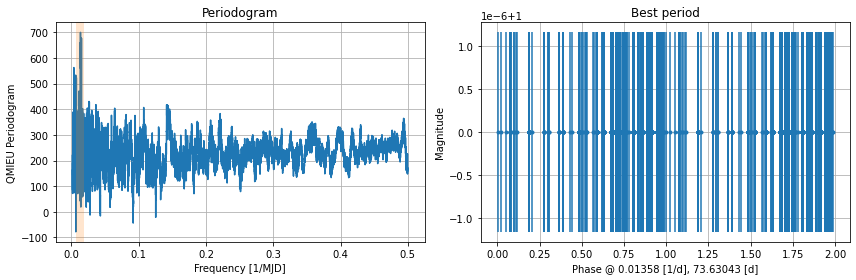

In [45]:
p4j_periodogram, p4j_period = p4j_search(bursts_p4j_method_search, pmin=2, pmax=300*2, plot=True, save=False, mjd_err=0.1)

# Plot results against each other

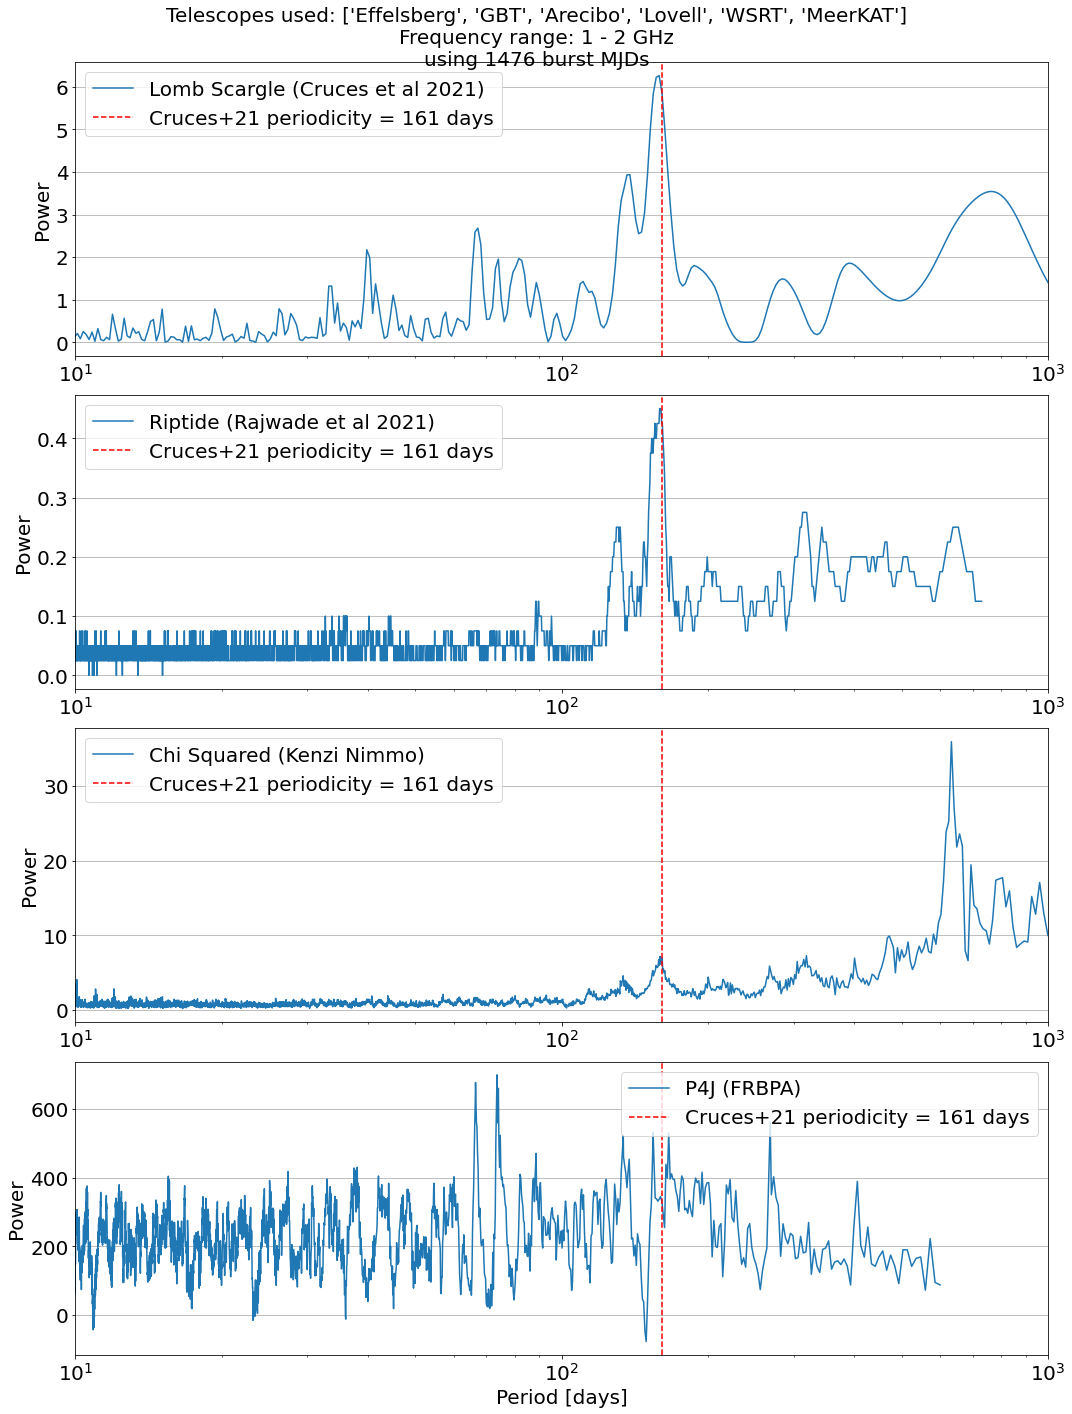

In [46]:

fig = plt.figure(figsize=(15,20))

plt.suptitle('Telescopes used: {0}\nFrequency range: {1} - {2} GHz\nusing {3} burst MJDs'.format(telescope_filter,
                                                                           minfreq_filter,
                                                                           maxfreq_filter,
                                                                           len(bursts_to_use)),
            fontsize=20)


ax = fig.add_subplot(411)
ax.set_ylabel('Power',fontsize=20)
ax.tick_params(axis='x',labelsize=20)
ax.tick_params(axis='y',labelsize=20)
ax.set_xscale('log')
ax.yaxis.grid(True)
#ax.set_ylim([-5,8])
ax.set_xlim([10,1000])

ax2 = fig.add_subplot(412)
ax2.set_ylabel('Power',fontsize=20)
ax2.tick_params(axis='x',labelsize=20)
ax2.tick_params(axis='y',labelsize=20)
ax2.set_xscale('log')
ax2.yaxis.grid(True)
#ax2.set_ylim([-5,8])
ax2.set_xlim([10,1000])

ax3 = fig.add_subplot(413)
ax3.set_ylabel('Power',fontsize=20)
ax3.tick_params(axis='x',labelsize=20)
ax3.tick_params(axis='y',labelsize=20)
ax3.set_xscale('log')
ax3.yaxis.grid(True)
#ax3.set_ylim([-5,8])
ax3.set_xlim([10,1000])

ax4 = fig.add_subplot(414)
ax4.set_ylabel('Power',fontsize=20)
ax4.set_xlabel('Period [days]',fontsize=20)
ax4.tick_params(axis='x',labelsize=20)
ax4.tick_params(axis='y',labelsize=20)
ax4.set_xscale('log')
ax4.yaxis.grid(True)
#ax4.set_ylim([-5,8])
ax4.set_xlim([10,1000])

ax.plot(periods_cruces,power_cruces,label='Lomb Scargle (Cruces et al 2021)')
ax.axvline(Cruces_p,color='r',ls='--',label='Cruces+21 periodicity = {0} days'.format(Cruces_p))
ax.legend(fontsize=20)

ax2.plot(rajwade_period, rajwade_cont_frac,label='Riptide (Rajwade et al 2021)')
ax2.axvline(Cruces_p,color='r',ls='--',label='Cruces+21 periodicity = {0} days'.format(Cruces_p))
ax2.legend(fontsize=20)

ax3.plot(periods_nimmo, powers_nimmo,label='Chi Squared (Kenzi Nimmo)')
ax3.axvline(Cruces_p,color='r',ls='--',label='Cruces+21 periodicity = {0} days'.format(Cruces_p))
ax3.legend(fontsize=20)

ax4.plot(p4j_period, p4j_periodogram,label='P4J (FRBPA)')
ax4.axvline(Cruces_p,color='r',ls='--',label='Cruces+21 periodicity = {0} days'.format(Cruces_p))
ax4.legend(fontsize=20)

plt.tight_layout()
plt.savefig('Burst_comparison_T_{0}'.format('_'.join(telescope_filter)))
plt.show()

In [47]:
print('_'.join(telescope_filter))

Effelsberg_GBT_Arecibo_Lovell_WSRT_MeerKAT
